<a href="https://colab.research.google.com/github/jeaneigsi/cat-classifier/blob/main/cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [99]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = '/content/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [100]:
# 3
train_image_generator = ImageDataGenerator(
    rescale=1./255
)
validation_image_generator= ImageDataGenerator(rescale=1./255,)
test_image_generator=ImageDataGenerator(rescale=1./255)

train_data_gen =train_image_generator.flow_from_directory(
    '/content/cats_and_dogs/train',
     target_size=(224, 224),
     batch_size=128,
     class_mode='binary',

)
val_data_gen = validation_image_generator.flow_from_directory(
     '/content/cats_and_dogs/validation',
     target_size=(224, 224),
     batch_size=128,
     class_mode='binary'

)
test_data_gen = test_image_generator.flow_from_directory(
    '/content/cats_and_dogs/test',
     target_size=(224, 224),
     batch_size=128,
     shuffle=True,
    classes=["."], #permet de considerer le path comme repertoire principale en l'abscence de sous repertoire
     class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


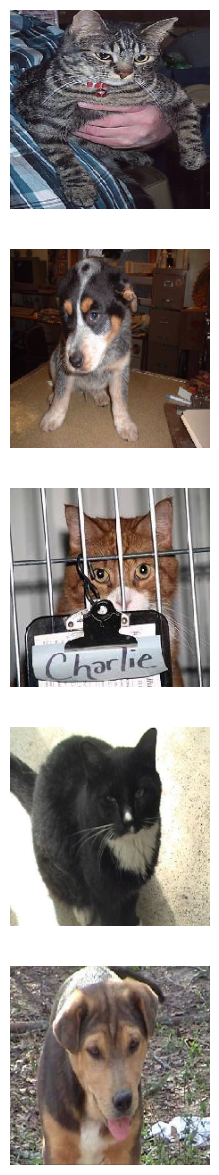

In [101]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [102]:
# 5
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.1,
    vertical_flip=False,
    horizontal_flip = True,
    rescale=1./255.,
    width_shift_range =0.1,
    height_shift_range =0.1,
    shear_range=0.1,
    brightness_range = [0.8, 1],
    fill_mode="nearest")


Found 2000 images belonging to 2 classes.
<class 'keras.src.preprocessing.image.DirectoryIterator'>


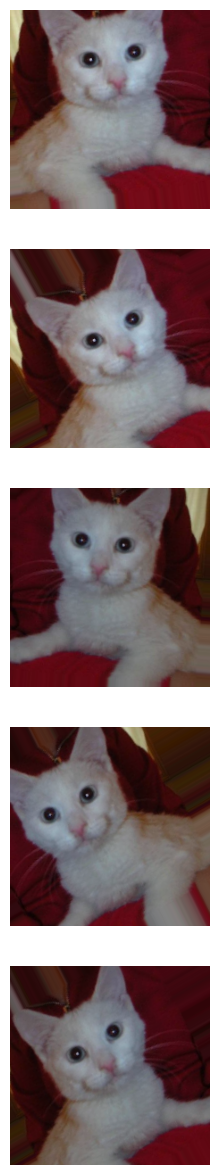

In [103]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
print(type(train_data_gen))
plotImages(augmented_images)

In [104]:
# 7 Definition du modèle avec 58% de précision

# model = Sequential(
#    [ tf.keras.layers.Conv2D(16, 3, activation = 'relu', input_shape = (150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(32, activation = 'relu'),
#     tf.keras.layers.Dense(32, activation = 'relu'),
#     tf.keras.layers.Dense(2, activation = 'softmax')]

# )

# model.compile( optimizer = 'adam',
#               loss = 'sparse_categorical_crossentropy',
#               metrics = ['accuracy']
# )

# model.summary()


In [105]:
# Geler les poids du modèle pré-entraîné par transfert learning 63%
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# # Créer le modèle séquentiel pour l'ajustement
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='sigmoid')  # Utilisation de 'sigmoid' car il s'agit d'un problème de classification binaire
])

# # Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Afficher un résumé du modèle
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 2)                 514       
                                                                 
Total params: 2586434 (9.87 MB)
Trainable params: 3284

In [106]:
from math import ceil

steps_per_epoch=ceil(len(train_data_gen)/batch_size)
steps_per_epoch

1

In [107]:
validation_steps = ceil(len(val_data_gen) / batch_size)
validation_steps

1

In [108]:
# 8
history = model.fit(
    train_data_gen, #generateur
    epochs=epochs,# episode
    validation_data=val_data_gen, # données de consideration
)

Epoch 1/20
16/16 [==============================] - 165s 10s/step - loss: 0.2564 - accuracy: 0.8950 - val_loss: 0.0875 - val_accuracy: 0.9710
Epoch 2/20
16/16 [==============================] - 198s 13s/step - loss: 0.1300 - accuracy: 0.9520 - val_loss: 0.0587 - val_accuracy: 0.9780
Epoch 3/20
16/16 [==============================] - 196s 12s/step - loss: 0.1008 - accuracy: 0.9545 - val_loss: 0.0589 - val_accuracy: 0.9770
Epoch 4/20
16/16 [==============================] - 192s 12s/step - loss: 0.0843 - accuracy: 0.9665 - val_loss: 0.0582 - val_accuracy: 0.9790
Epoch 5/20
16/16 [==============================] - 191s 12s/step - loss: 0.1008 - accuracy: 0.9600 - val_loss: 0.0580 - val_accuracy: 0.9780
Epoch 6/20
16/16 [==============================] - 153s 10s/step - loss: 0.0864 - accuracy: 0.9655 - val_loss: 0.0622 - val_accuracy: 0.9730
Epoch 7/20
16/16 [==============================] - 153s 10s/step - loss: 0.0777 - accuracy: 0.9680 - val_loss: 0.0629 - val_accuracy: 0.9770
Epoch 

In [109]:
# model.save('cat_detector_58.h5')

In [110]:
#model.save('cat_detctor_59.keras')

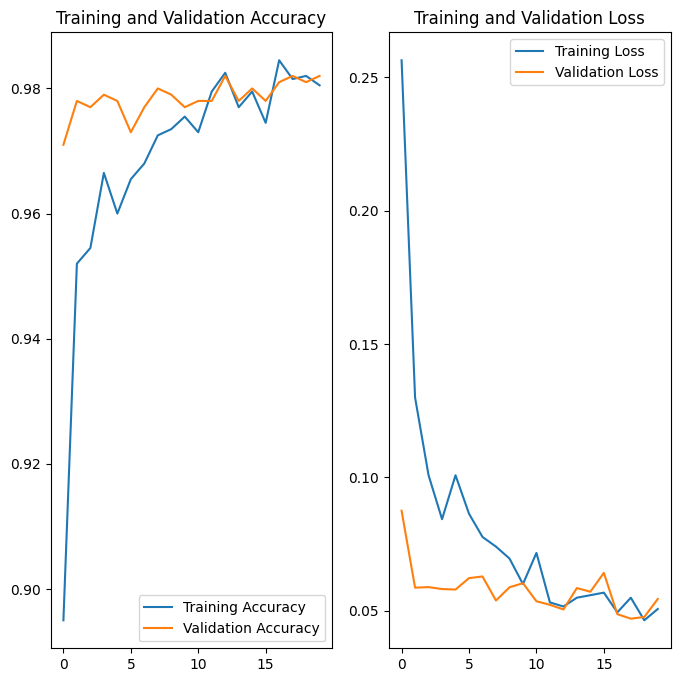

In [111]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [112]:
predictions=model.predict(test_data_gen,verbose=1)
print(predictions)
probabilities = []
for a in predictions:
  if a[0] > a[1]:
    probabilities.append(0)
  else:
    probabilities.append(1)


1/1 [==============================] - 3s 3s/step
[[0.63242483 0.25383225]
 [0.99922705 0.00423234]
 [0.00430248 0.99861044]
 [0.9977083  0.00805896]
 [0.9964718  0.01033753]
 [0.00232904 0.9994379 ]
 [0.11199586 0.9968975 ]
 [0.9988311  0.00438139]
 [0.9981206  0.01768661]
 [0.00490887 0.9981047 ]
 [0.9999327  0.00175181]
 [0.1185094  0.9821236 ]
 [0.99924904 0.01296869]
 [0.9983874  0.00688519]
 [0.8434996  0.7751245 ]
 [0.7326379  0.70536035]
 [0.0021117  0.9991423 ]
 [0.9982353  0.01279098]
 [0.99627995 0.01088113]
 [0.85532886 0.60002464]
 [0.9906981  0.04296078]
 [0.13407993 0.99505395]
 [0.00971785 0.9951797 ]
 [0.98191196 0.05305076]
 [0.00692378 0.9441335 ]
 [0.9976118  0.01424837]
 [0.08418605 0.9576498 ]
 [0.02490265 0.96350235]
 [0.99940175 0.00683652]
 [0.9988784  0.00690155]
 [0.99937916 0.00296102]
 [0.5631345  0.83208495]
 [0.9996159  0.00593872]
 [0.999643   0.00174304]
 [0.9995524  0.00303252]
 [0.03058759 0.9967338 ]
 [0.01844206 0.99502516]
 [0.03870965 0.9874985 ]


In [113]:
print(len(probabilities))
print(type(probabilities))



50
<class 'list'>


[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]


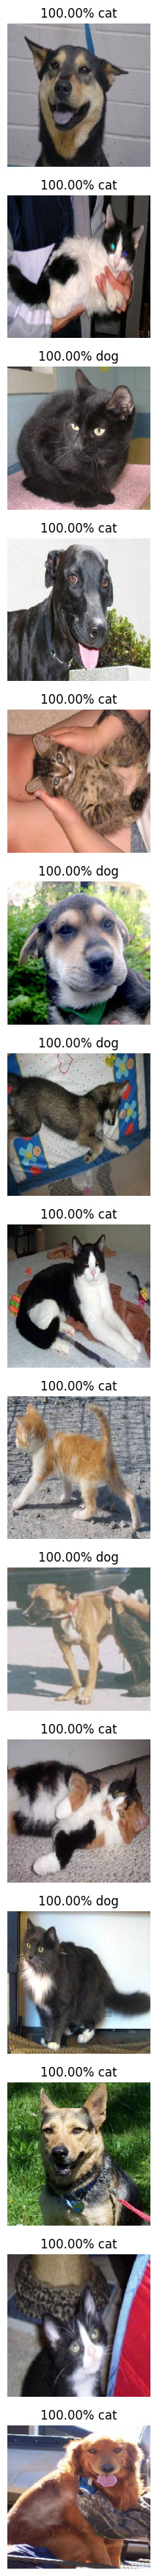

In [114]:
sample_training_images, _ = next(test_data_gen)
print(probabilities)
plotImages(sample_training_images[:15], probabilities)
#0=chat et 1=chien

In [128]:
# 11
answers =  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 1, 0, 0]
print(len(answers))
correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

50
Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
